In [178]:
import utils
import xarray as xr
import pandas as pd
import numpy as np
import fair
import matplotlib.pyplot as plt

In [55]:
GWP_table = pd.read_csv("../../dependencies/AR6_GWP_values.csv")

In [96]:
ghgs = np.array(f.species)[f._ghg_indices]

alternative_names = {
    'c-C4F8': 'PFC-C-318',
    'C4F10': 'PFC-31-10',
    'C5F12': 'PFC-41-12',
    'C6F14': 'PFC-51-14',
    'C7F16': 'PFC-61-16',
    'C8F18': 'PFC-71-18',
    'HFC-4310mee': 'HFC-43-10mee'
}


GWP_100 = {}
for specie in ghgs:
    if specie in GWP_table.Formula.values:
        GWP_100[specie] = GWP_table.loc[GWP_table.Formula.values == specie]["GWP100"].item()
    elif specie in GWP_table.Acronym.values:
        GWP_100[specie] = GWP_table.loc[GWP_table.Acronym.values == specie]["GWP100"].item()
    elif specie in alternative_names.keys():
        key = alternative_names[specie]
        GWP_100[specie] = GWP_table.loc[GWP_table.Acronym.values == key]["GWP100"].item()
    else:
        print(specie)

In [139]:
unit_conversion = {}
units = fair.structure.units.desired_emissions_units
for unit in units.keys():
    if units[unit].split()[0] == "Gt":
        unit_conversion[unit] = 1e3
    if units[unit].split()[0] == "Mt":
        unit_conversion[unit] = 1
    if units[unit].split()[0] == "kt":
        unit_conversion[unit] = 1e-3

In [195]:
f = utils.gen_fair_ensemble(["ssp534-over"], final_year=2200)

In [196]:
f._make_indices()

In [197]:
emissions = f.emissions.isel(scenario=0, config=0)

In [198]:
emissions[:,2] = emissions[:,0] + emissions[:,1]  

In [199]:
ghg_emissions = emissions[:, f._ghg_indices]

In [200]:
for specie in ghg_emissions.specie:
    ghg_emissions[:, ghg_emissions.specie == specie] = GWP_100[specie.item()]*unit_conversion[specie.item()]*ghg_emissions[:, ghg_emissions.specie == specie]/1e3

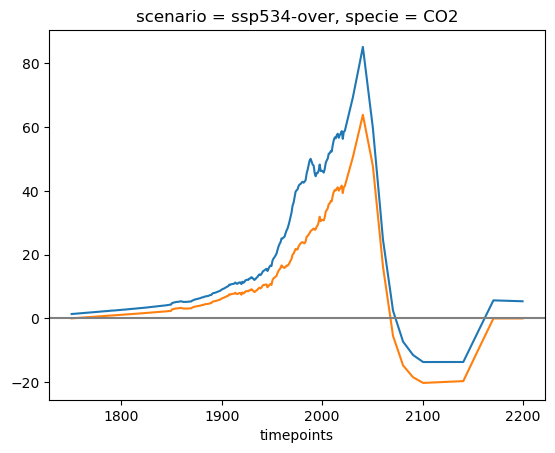

In [201]:
ghg_emissions.sum("specie").plot()
ghg_emissions.sel(specie="CO2").plot()
plt.axhline(0, color="grey")

In [ ]:
Now we need to compute the year of net-zero based on the GWPs. From the model itself or for the 

In [13]:
def ZEC_emissions(f, year):

    # Original behavior: set all emissions to baseline after ZEC_year                                                                                                  
    future = f.emissions.where(f.emissions.timepoints > year, drop=True)                                                                                           
    future = future.fillna(0.0) * 0 + f.species_configs.baseline_emissions                                                                                             
    past = f.emissions.where(f.emissions.timepoints <= year, drop=True)                                                                                            
    f.emissions = xr.concat([past, future], dim="timepoints")    

In [14]:
ZEC_emissions(f, year=2020)

In [23]:
def get_ssps():
    prefix = "../../datasets/fair_calibrate"                                                                                                                                                
    fair_v = "2.1.3"                                                                                                                                                                        
    cal_v = "1.4"                                                                                                                                                                           
    constraint_set = "all-2022"                                                                                                                                                                                                                                                                                                                                                                                                                                                   
    emissions_file = prefix + f"/output/fair-{fair_v}/v{cal_v}/{constraint_set}/emissions/ssps_harmonized_1750-2499.nc" 
    ssp_emissions = ssp_emissions.where(~ssp_emissions.specie.isin(["Solar", "Volcanic"]), drop=True) 
    return ssp_emissions

In [24]:
ssp_emissions = get_ssps()

In [ ]:
    #fill emissions                                                                                                                                                                                                                                                          
    # Emissions loading and initialization                                                                                                                                                                                                                                   
                                                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                             
    if zero_CO2_only:                                                                                                                                                                                                                                                        
        # Define CO2 species                                                                                                                                                                                                                                                 
        co2_species = ["CO2 FFI", "CO2 AFOLU"]                                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                             
        # Select CO2 emissions at all timepoints                                                                                                                                                                                                                             
        co2_emissions = f.emissions.sel(specie=co2_species)                                                                                                                                                                                                                  
                                                                                                                                                                                                                                                                             
        # Sum of CO2 emissions over the specie dimension                                                                                                                                                                                                                     
        total_co2_emissions = co2_emissions.sum(dim="specie")                                                                                                                                                                                                                
                                                                                                                                                                                                                                                                             
        # Find timepoints where the sum of CO2 emissions is negative                                                                                                                                                                                                         
        negative_timepoints = total_co2_emissions.where(                                                                                                                                                                                                                     
            total_co2_emissions <= 0, drop=True                                                                                                                                                                                                                              
        ).timepoints                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                             
        # check if there are any negative timepoints                                                                                                                                                                                                                         
        if negative_timepoints.size > 0:                                                                                                                                                                                                                                     
            # Select baseline CO2 emissions                                                                                                                                                                                                                                  
            baseline_co2 = f.species_configs.baseline_emissions.sel(specie=co2_species)                                                                                                                                                                                      
                                                                                                                                                                                                                                                                             
            # Assign baseline emissions to CO2 species at negative timepoints                                                                                                                                                                                                
            f.emissions.loc[dict(                                                                                                                                                                                                                                            
                specie=co2_species, timepoints=negative_timepoints                                                                                                                                                                                                           
            )] = baseline_co2                                                                                                                                                                                                                                                
                                                                                                                                                                                                                                                                             
        # For non-CO2 emissions after 2100, set to constant values (emissions at 2100)                                                                                                                                                                                       
        non_co2_species = [specie for specie in f.emissions.specie.values if specie not in co2_species]                                                                                                                                                                      
        future_timepoints_non_co2 = f.emissions.timepoints.where(                                                                                                                                                                                                            
            f.emissions.timepoints >= 2300, drop=True                                                                                                                                                                                                                        
        )                                                                                                                                                                                                                                                                    
                                                                                                                                                                                                                                                                             
        # Check if there are any future timepoints beyond 2100                                                                                                                                                                                                               
        if future_timepoints_non_co2.size > 0:                                                                                                                                                                                                                               
            # Get emissions at 2100 for non-CO2 species                                                                                                                                                                                                                      
            emis_2300 = f.emissions.sel(timepoints=1750, method="nearest").sel(specie=non_co2_species)                                                                                                                                                                       
                                                                                                                                                                                                                                                                             
            # Assign emissions at 2100 to future timepoints for non-CO2 species                                                                                                                                                                                              
            f.emissions.loc[dict(                                                                                                                                                                                                                                            
                specie=non_co2_species, timepoints=future_timepoints_non_co2                                                                                                                                                                                                 
            )] = emis_2300                                                                                                                                                                                                                                                   
    else:                                                                                                                                                                                                                                                                    
        # Original behavior: set all emissions to baseline after ZEC_year                                                                                                                                                                                                    
                                                                                                                                                                                                       

                                                                                                      
                                                                          

In [ ]:
    anthro_emis = anthro_emis.loc[dict(config="unspecified")]                                                                                                                                                                                                                
    f.emissions = (                                                                                                                                                                                                                                                          
        anthro_emis.expand_dims(dim=["config"], axis=(2))                                                                                                                                                                                                                    
        .drop("config")                                                                                                                                                                                                                                                      
        * np.ones((1, 1, ensemble_members, 1))                                                                                                                                                                                                                               
    )                